<a href="https://colab.research.google.com/github/lenasarien/Artrade-base-smart-contract/blob/main/NLP_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analyse + Deep Learn - Amazon App

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
! pip install google-play-scraper
from google_play_scraper import Sort, reviews_all, app, reviews
! pip install app-store-scraper
from app_store_scraper import AppStore
! pip install langdetect
from langdetect import detect
import random


In [ ]:
import re
!pip install unidecode
import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

## 1- Introduction

De nombreuses informations textuelles sont disponibles sur le Web pour comprendre le sentiment des utilisateurs concernant des sites Web, produits ou marques via des tweets et des avis. Lire chaque avis est impossible sans une √©ternit√©, mais former un ordinateur √† le faire est une solution efficace.

Ce projet vise √† cr√©er un mod√®le d'apprentissage profond pour analyser et classer automatiquement les sentiments des utilisateurs en positifs, neutres et n√©gatifs et ensuite g√©n√©rer des recommandations issues de cette apprentissage, pour aider √† l'am√©lioration de la satisfaction client.




## 2- Les donn√©es

Dans ce projet, nous utiliserons les avis en fran√ßais sur l'application Amazon Shopping, extraits de l'Apple Store et du Playstore √† l'aide de Google_Play_Scraper et de l'API App_Store_Scraper. Les donn√©es fusionn√©es forment un DataFrame avec deux colonnes : ¬´ Avis ¬ª (str) et ¬´ Scores ¬ª (int), o√π les notes varient de 1 √† 5.

## 3- M√©thodologie

Pour identifier le meilleur mod√®le de classification de texte multi-√©tiquettes, nous commencerons par pr√©traiter notre texte via un pipeline incluant les expressions r√©guli√®res, la suppression des mots vides et la lemmatisation. Ensuite, nous analyserons nos donn√©es en tra√ßant les N-grams courants, la distribution des sentiments et un nuage de mots pour chaque sentiment. Avant la mod√©lisation, nous diviserons les donn√©es en ensembles de test et d'entra√Ænement, vectoriserons, √©quilibrerons l'ensemble, et cr√©erons des fonctions pour l'√©valuation du mod√®le. Nous construirons un r√©seau neuronal pour la classification multi-√©tiquettes, suivi d'une fonction qui appliquera ce mod√®le et affichera les pr√©dictions et pourcentages pour chaque avis ajout√©.

## 4- Extraction de donn√©es

## 4.1 - Web Scrapping

In [2]:
# Liste des pays par code
countries = {
    "Afrique du Sud": "za",
    "Nig√©ria": "ng",
    "√âgypte": "eg",
    "Inde": "in",
    "Chine": "cn",
    "Japon": "jp",
    "France": "fr",
    "Allemagne": "de",
    "Royaume-Uni": "gb",
    "√âtats-Unis": "us",
    "Canada": "ca",
    "Mexique": "mx",
    "Br√©sil": "br",
    "Argentine": "ar",
    "Colombie": "co",
    "Australie": "au",
    "Nouvelle-Z√©lande": "nz"
}

# Liste pour stocker les r√©sultats
all_reviews = []

# Identifiant de l'application Amazon Shopping
app_package_name = 'com.amazon.mShop.android.shopping'

# R√©cup√©ration des avis pour chaque pays
for country_name, country_code in countries.items():
    num_reviews = random.randint(200, 5000)  # Nombre al√©atoire d'avis entre 100 et 2000
    reviews_result, continuation_token = reviews(
        app_package_name,
        lang='fr',  # Langue fran√ßaise (ou changez pour 'en' si n√©cessaire)
        country=country_code,  # Code du pays
        count=num_reviews,  # Nombre d'avis √† r√©cup√©rer
        filter_score_with=None  # Aucun filtre de score
    )

    # Stockage des avis avec l'indication du pays
    for review in reviews_result:
        review_data = {
            'score': review['score'],
            'review': review['content'],
            'date': review['at'],
            'country': country_name
        }
        all_reviews.append(review_data)

# Cr√©ation d'un DataFrame
df_reviews = pd.DataFrame(all_reviews)

# Affichage des premiers r√©sultats
df_reviews.head()

score                                             review  \
0      5  toujours aussi r√©active avec des livraisons au...   
1      3                                      Kaka Fr√©d√©ric   
2      5  L'appli ne fonctionne plus depuis un moment es...   
3      1  J'esp√®re que cette application est GRATUITE ca...   
4      1  Impossible de se connecter au Locker et donc d...   

                 date         country  
0 2024-07-29 14:06:53  Afrique du Sud  
1 2024-07-29 09:39:16  Afrique du Sud  
2 2024-07-29 09:09:42  Afrique du Sud  
3 2024-07-29 08:36:34  Afrique du Sud  
4 2024-07-29 08:13:34  Afrique du Sud

In [3]:
df_reviews.shape

(39370, 4)

In [4]:
# Liste des pays francophones par code
francophone_countries = {
    "France": "fr",
    "Belgique": "be",
    "Suisse": "ch",
    "C√¥te d'Ivoire": "ci",
    "S√©n√©gal": "sn",
    "Mali": "ml",
    "Cameroun": "cm",
    "Maroc": "ma",
    "Alg√©rie": "dz",
    "Tunisie": "tn",
    "Canada": "ca",
    "Ha√Øti": "ht",
    "Nouvelle-Cal√©donie": "nc",
    "Liban": "lb"
}

# Fonction pour r√©cup√©rer les avis d'un pays sp√©cifique
def get_reviews_from_country(app_name, country_name, country_code):
    app = AppStore(country=country_code, app_name=app_name)
    app.review(how_many= random.randint(200, 10000))

    reviews = []
    for review in app.reviews:
        # D√©tection de la langue de l'avis
        try:
            if detect(review['review']) == 'fr':
                review_data = {
                    'score': review['rating'],
                    'review': review['review'],
                    'date': review['date'],
                    'country': country_name
                }
                reviews.append(review_data)
        except:
            # Ignorer les erreurs de d√©tection de langue
            continue

    return reviews

# Collecte des avis pour chaque pays francophone
all_reviews_app_store = []
app_name = "amazon-shopping"  # Identifiant de l'application sur l'App Store

for country_name, country_code in francophone_countries.items():
    reviews = get_reviews_from_country(app_name, country_name, country_code)
    all_reviews_app_store.extend(reviews)

# Cr√©ation d'un DataFrame pour les avis de l'App Store
df_reviews_app_store = pd.DataFrame(all_reviews_app_store)

# Affichage des premiers r√©sultats
df_reviews_app_store.head()

ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/fr/apps/297606951/reviews?l=en-GB&offset=0&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 429 error responses'))
ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/be/apps/297606951/reviews?l=en-GB&offset=0&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 429 error responses'))
ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/ch/apps/297606951/reviews?l=en-GB&offset=0&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 429 error responses'))
ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.

Empty DataFrame
Columns: []
Index: []

In [5]:
df_reviews_app_store.shape


(0, 0)

In [6]:
# Fusion des DataFrames
amazon_reviews = pd.concat([df_reviews, df_reviews_app_store], ignore_index=True)

# Affichage des r√©sultats fusionn√©s
amazon_reviews.head()


score                                             review  \
0      5  toujours aussi r√©active avec des livraisons au...   
1      3                                      Kaka Fr√©d√©ric   
2      5  L'appli ne fonctionne plus depuis un moment es...   
3      1  J'esp√®re que cette application est GRATUITE ca...   
4      1  Impossible de se connecter au Locker et donc d...   

                 date         country  
0 2024-07-29 14:06:53  Afrique du Sud  
1 2024-07-29 09:39:16  Afrique du Sud  
2 2024-07-29 09:09:42  Afrique du Sud  
3 2024-07-29 08:36:34  Afrique du Sud  
4 2024-07-29 08:13:34  Afrique du Sud

In [7]:
# V√©rification des doublons
print(amazon_reviews.duplicated().sum())

0


In [8]:
# V√©rification des valeurs manquantes
print(amazon_reviews.isnull().sum())

score      0
review     0
date       0
country    0
dtype: int64


In [9]:
# Enregistrement du DataFrame au format CSV
amazon_reviews.to_csv('amazon_reviews.csv', index=False)


## 4.2 - V√©rification des donn√©es

In [10]:
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39370 entries, 0 to 39369
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   score    39370 non-null  int64         
 1   review   39370 non-null  object        
 2   date     39370 non-null  datetime64[ns]
 3   country  39370 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.2+ MB


In [11]:
amazon_reviews['score'].value_counts()

score
5    15068
1    15052
4     3518
3     2887
2     2845
Name: count, dtype: int64

In [12]:
amazon_reviews['country'].value_counts()

country
Afrique du Sud      4710
Argentine           3692
√âtats-Unis          3607
Canada              3139
Chine               3044
Nouvelle-Z√©lande    2911
Inde                2344
Nig√©ria             2317
Allemagne           2190
Mexique             2177
Japon               2042
Royaume-Uni         1728
Colombie            1710
France              1516
Australie            770
Br√©sil               744
√âgypte               729
Name: count, dtype: int64

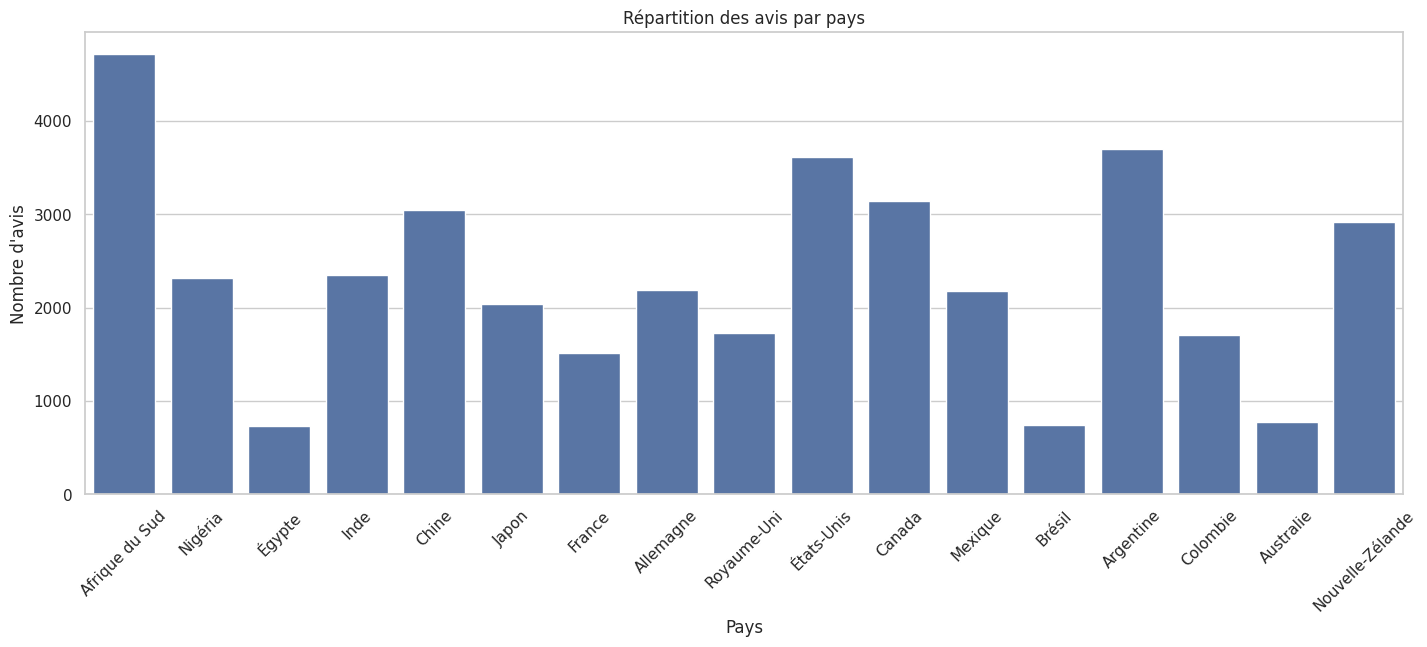

In [13]:
# Visualisation de la r√©partition des classes
sns.set(style="whitegrid")
plt.figure(figsize=(17, 6))
sns.countplot(x='country', data=amazon_reviews)
plt.title('R√©partition des avis par pays')
plt.xlabel('Pays')
plt.ylabel("Nombre d'avis")
plt.xticks(rotation=45)
plt.show()

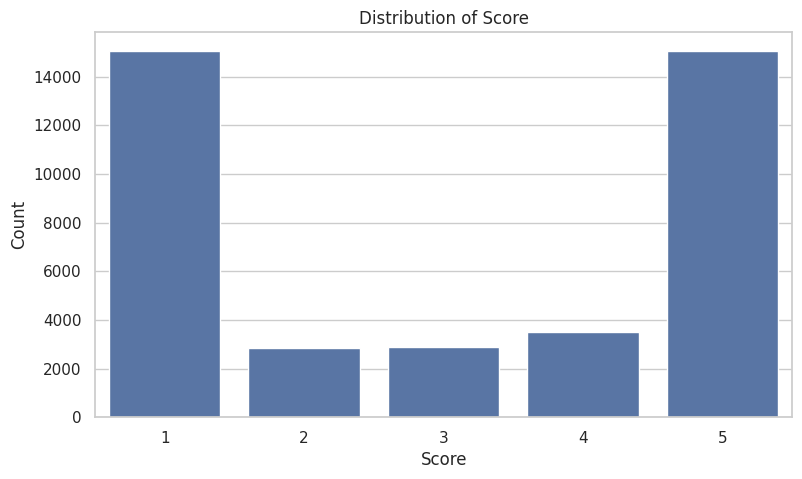

In [14]:
# Visualisation de la repartition par score
sns.set(style="whitegrid")
plt.figure(figsize=(9, 5))
sns.countplot(data=amazon_reviews, x='score')
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [15]:
def Sentiment_analysis(score):

    # Classifying based on Score
    if score > 3 :
        return 'Positive'
    elif score < 3 :
        return 'Negative'
    else:
        return 'Neutral'

# Applying TextBlob sentiment analysis to the reviews
amazon_reviews['sentiment'] = amazon_reviews['score'].apply(Sentiment_analysis)

amazon_reviews.head(20)

score                                             review  \
0       5  toujours aussi r√©active avec des livraisons au...   
1       3                                      Kaka Fr√©d√©ric   
2       5  L'appli ne fonctionne plus depuis un moment es...   
3       1  J'esp√®re que cette application est GRATUITE ca...   
4       1  Impossible de se connecter au Locker et donc d...   
5       5                            rapide pr√©cise parfaite   
6       4                                   C'est cool'os !!   
7       3  C'est bien et pratique car c'est rapide parcon...   
8       5  Tr√®s content d amazon ils y a tous pas besoin ...   
9       1  P√©nible. oblig√© d'utiliser l'app pour retirer ...   
10      1  Mon application est passe en mode USA, pas tre...   
11      5               G√©niale application suivi colis ect!   
12      5  C'est g√©nial car on trouve vraiment de tout ! ...   
13      5                    Tr√®s satisfaite de mes achats üëå   
14      1  Impossible de supprimer ou de mettre de c√¥t√© d...   
15      1   Indisponible au liban et pas de cash on delivery   
16      1  Application de voleurs : J'ai fait une command...   
17      5      Pk l'application est bloqu√© sur mon t√©l√©phone   
18      5                               une application top!   
19      5                                  Rien √† dire ‚ô•Ô∏èüëç‚úåÔ∏è   

                  date         country sentiment  
0  2024-07-29 14:06:53  Afrique du Sud  Positive  
1  2024-07-29 09:39:16  Afrique du Sud   Neutral  
2  2024-07-29 09:09:42  Afrique du Sud  Positive  
3  2024-07-29 08:36:34  Afrique du Sud  Negative  
4  2024-07-29 08:13:34  Afrique du Sud  Negative  
5  2024-07-29 08:07:53  Afrique du Sud  Positive  
6  2024-07-29 01:23:02  Afrique du Sud  Positive  
7  2024-07-28 17:25:47  Afrique du Sud   Neutral  
8  2024-07-28 15:51:27  Afrique du Sud  Positive  
9  2024-07-28 14:04:15  Afrique du Sud  Negative  
10 2024-07-28 13:29:00  Afrique du Sud  Negative  
11 2024-07-28 13:28:20  Afrique du Sud  Positive  
12 2024-07-28 13:24:09  Afrique du Sud  Positive  
13 2024-07-28 10:55:37  Afrique du Sud  Positive  
14 2024-07-28 09:04:47  Afrique du Sud  Negative  
15 2024-07-28 00:59:19  Afrique du Sud  Negative  
16 2024-07-27 16:58:35  Afrique du Sud  Negative  
17 2024-07-27 14:26:44  Afrique du Sud  Positive  
18 2024-07-27 08:36:21  Afrique du Sud  Positive  
19 2024-07-26 16:36:38  Afrique du Sud  Positive

In [16]:
# Agr√©ger les donn√©es par pays et par score
pivot_data = amazon_reviews.pivot_table(index='country', columns='score', values='review', aggfunc='count', fill_value=0)

# R√©organiser les colonnes pour avoir les scores de 1 √† 5
pivot_data = pivot_data.sort_index(axis=1)

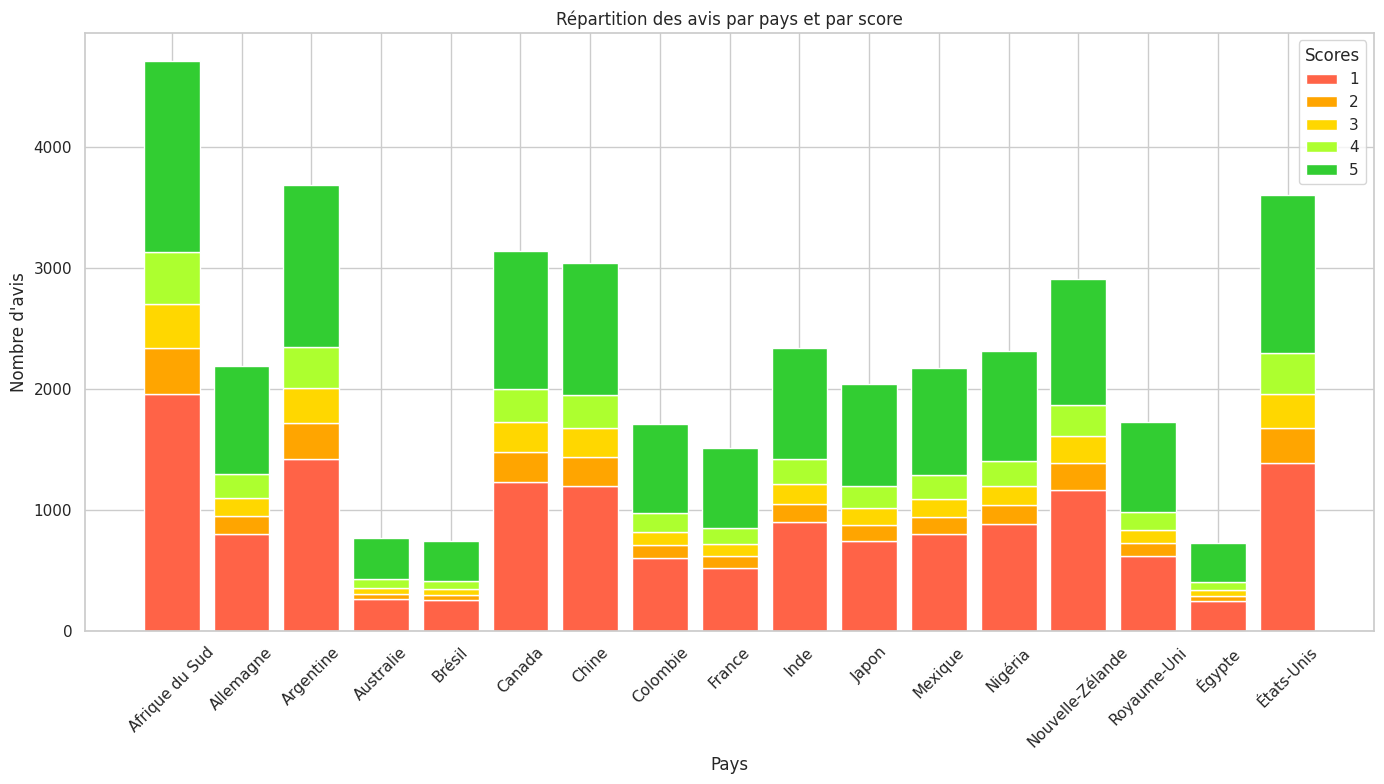

In [17]:
# Pr√©paration des donn√©es pour le graphique
pays = pivot_data.index
scores = pivot_data.columns
colors = ['#FF6347', '#FFA500', '#FFD700', '#ADFF2F', '#32CD32']  # Couleurs pour chaque score

# Cr√©ation des barres empil√©es
bottoms = np.zeros(len(pays))  # Initialise le bas de chaque barre √† 0

plt.figure(figsize=(14, 8))

for i, score in enumerate(scores):
    plt.bar(pays, pivot_data[score], bottom=bottoms, color=colors[i], label=f'{score}')
    bottoms += pivot_data[score]  # Met √† jour le bas pour le prochain empilement

# Configuration du graphique
plt.xlabel('Pays')
plt.ylabel('Nombre d\'avis')
plt.title('R√©partition des avis par pays et par score')
plt.legend(title='Scores')
plt.xticks(rotation=45)  # Rotation des labels des pays pour une meilleure lisibilit√©

# Affichage du graphique
plt.tight_layout()
plt.show()

In [18]:
df = amazon_reviews.drop(['date', 'score'], axis=1)
df.head()

review         country sentiment
0  toujours aussi r√©active avec des livraisons au...  Afrique du Sud  Positive
1                                      Kaka Fr√©d√©ric  Afrique du Sud   Neutral
2  L'appli ne fonctionne plus depuis un moment es...  Afrique du Sud  Positive
3  J'esp√®re que cette application est GRATUITE ca...  Afrique du Sud  Negative
4  Impossible de se connecter au Locker et donc d...  Afrique du Sud  Negative

# 5 - Traitement de texte

Pour la validation future de notre mod√®le, nous allons cr√©er un pipeline de pr√©traitement du texte. Celui-ci inclura des fonctions pour¬†:

* mettre le texte en minuscules¬†;
* supprimer le HTML¬†;
* retirer les caract√®res accentu√©s¬†;
* d√©velopper les contractions¬†;
* enlever les caract√®res sp√©ciaux¬†;
* effectuer la lemmatisation¬†;
* supprimer les mots vides¬†;
* v√©rifier si le mot est en fran√ßais¬†;
* retirer les chiffres et les espaces blancs dupliqu√©s.

## 5.1 - Formatage du texte : uniformiser le texte en minuscule et supprimer le html

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def re_tags(text_list):
    return [TAG_RE.sub('', str(word)).lower() for word in text_list]
